# Key-Value Memory Network

This project will be working with attention mechanism for question-answering. We will build a Key-Value Memory Network model to which the external memory store is organized as a dictionary with keys and values. 

Given a question, e.g., "Where was Alexander Hamilton born?", a key-value memory network learns an embedding such that the question has a high cosine similarity to a particular key in the external dictionary. Because there are many keys that need to be matched against, key-value memory networks implement an attention-scoring mechanism to select a key. Because attention is a probabilistic score, the key-value memory network retrieves a sum of embeddings weighted according to the attention score. This weighted embedding is then compared to values using a second attention-scoring mechanism. The value with the highest cosine similarity can then be retrieved and returned as the answer.

Key-value memory networks are described in this [paper](https://arxiv.org/abs/1606.03126). 

# Some imports



In [1]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import re
import os
import json
import random
import numpy as np
import pickle
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

Unidecode is useful for getting rid of issues that arise from unicode. This should not be used if we care about unicode, but for the purposes of an instructional exercise, it eliminates a lot of edge cases that come up with unicode.

In [ ]:
!pip install unidecode

In [3]:
import unidecode

If you need to have a reduced vocabulary, you can create an unknown "unk" token and add it to the vocabulary. Make sure the token index in the vocabulary and `UNK_ID` match.

In [6]:
UNK = 'unk'
UNK_ID = '0'

# Some utilities

Stem words

In [7]:
# Stemming the text
def simple_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= [ps.stem(word) for word in text]
    return text

Simple tokenizer that only keeps letters and numbers.

In [4]:
def tokenize(line):
    line = re.sub(r'[^a-zA-Z0-9]', ' ', unidecode.unidecode(line)) # remove punctuation
    line = line.lower().split()  # lower case
    return line

A standard vocabulary object class

In [5]:
class Vocab:
    def __init__(self, name = 'vocab'):
        self.name = name
        self._word2index = {}
        self._word2count = {}
        self._index2word = {}
        self._n_words = 0

    def get_words(self):
        return list(self._word2count.keys())

    def num_words(self):
        return self._n_words

    def word2index(self, word):
        return self._word2index[word]

    def index2word(self, word):
        return self._index2word[word]

    def word2count(self, word):
        return self._word2count[word]

    def add_sentence(self, sentence):
        for word in tokenize(sentence):
            self.add_word(word)

    def add_word(self, word):
        if word not in self._word2index:
            self._word2index[word] = self._n_words
            self._word2count[word] = 1
            self._index2word[self._n_words] = word
            self._n_words += 1
        else:
            self._word2count[word] += 1

Make a bag of words from a sentence, given a vocabulary. Can return a bag of word counts or a a bag of word presences.

In [ ]:
pip install gensim

In [6]:
import gensim.downloader as api
glove_vectors = api.load('glove-wiki-gigaword-100')  # 100d GloVe
glove_dim = glove_vectors.vector_size  # 100

[==================================================] 100.0% 128.1/128.1MB downloaded


In [7]:
def sentence_embedding(s, glove_vectors, dim=glove_dim):
    tokens = tokenize(s)
    vectors = [glove_vectors[t] for t in tokens if t in glove_vectors]
    if len(vectors) == 0:
        return np.zeros(dim, dtype=np.float32)
    return np.mean(vectors, axis=0)

# Part A: Download and Process Data

This dataset contains the information in tables that are commonly used in Wikipedia biography pages. Each person has different rows of information pertaining to their notable accomplishments and details about their life. There are a large number of types of information that can appear as rows in the biography tables, however they are relatively uniform. We call the keys of the rows "relations".

For example [Alexander Hamilton](https://en.wikipedia.org/wiki/Alexander_Hamilton) has information about the President he worked for as Secretary of State, birth date, date of death, parents' names, etc.

The code below will download the dataset and process it to create two things:
- `DB`: a hash table that map titles of biography wikipedia articles to table information. The table information is represented as a nested hash table containing relations as keys, and associated values. For example, `DB['alexander hamilton'] = {'party': 'federalist',
 'spouse': 'elizabeth schuyler', ...}`
- `VOCAB`: A vocabulary object that maps words to tokens and vice versa.

In [ ]:
!git clone https://github.com/rlebret/wikipedia-biography-dataset.git

In [ ]:
!cat wikipedia-biography-dataset/wikipedia-biography-dataset.z?? > tmp.zip
!unzip -o tmp.zip
!rm tmp.zip

Get all the wikipedia titles.

In [ ]:
train_titles = []
with open("wikipedia-biography-dataset/train/train.title", "r") as file:
    for line in file:
        train_titles.append(line.rstrip())

Boxes contain all the information, with each line corresponding to a title in `titles`.

In [ ]:
train_boxes = []
with open("wikipedia-biography-dataset/train/train.box", "r") as file:
    for line in file:
        train_boxes.append(line.rstrip())

This will make the DB object, a dictionary of dictionaries for each wikipedia title, which is more or less the same as names. This function only keeps politicians (containing the "office" key term) and strips out information about images. It can be improved in many ways.

In [ ]:
# Make a dictionary of dictionaries
def make_db(titles, boxes):
    db = {} # The DB
    # Iterate through titles
    for i in tqdm(range(len(titles))):
    box = boxes[i] # Grab the corresponding box information
    d  = {} # Inner dictionary
    # Build a dict for the ith entry
    # grab each key:value pair
    for pair in re.findall(r'([a-zA-Z_]+)[0-9]*\:([\w\d]+)', box):
        key, value = pair
        # Do a bit of cleaning
        key = key.strip()
        value = value.strip()
        # If the key contains the word image, we probably don't want to keep it
        if 'image' not in key:
            # The regex maintains underscores, strip those off
            if key[-1] == '_':
                key = key[:-1]
            # Make a new entry in inner dictionary if we don't have one
            if key not in d:
                d[key] = value
            # Keys with compound values are split up, which is annoying, so put them back together
        else:
            d[key] += ' ' + value
    # If it has an office key, keep it.
    if 'office' in d:
        db[titles[i]] = d
        return db

Build the vocab from the DB. Convert the whole thing into a string, tokenize it, and feed the surviving words into the vocab.

In [ ]:
def make_vocab(DB):
  # Make the vocab object
  vocab = Vocab()
  # Tokenize the data by converting the entire DB into a string
  tokens = tokenize(str(DB))
  # Iterate through all the tokens (tqdm provides a progress bar)
  for t in tqdm(tokens):
    vocab.add_word(t)
      return vocab

If you want to discard rare words, this will rebuild the vocab. This is just an example.

In [ ]:
def reduce_vocab(vocab, min_word_occurrence = 2):
  # make a new vocab
  vocab2 = Vocab("top")
  # Add the UNK token
  vocab2.add_word(UNK)
  # Iterate through vocabulary
  for w in list(vocab._word2count.keys()):
    count = vocab._word2count[w]
    idx = vocab._word2index[w]
    # If the word count passes threshold, add it to the new vocabulary object
    if count >= min_word_occurrence:
        vocab2.add_word(w)
        vocab2._word2count[w] = count
  # Return the new vocabulary object
  return vocab2

Make the DB

In [ ]:
DB = make_db(train_titles, train_boxes)

Make the VOCAB

In [ ]:
VOCAB = make_vocab(DB)
print(VOCAB.num_words())

## Save Processed Data

You may find it useful to save the processed dataset to your Google Drive.

It is recommended that you save the file to your Google Drive. To mount your Google Drive, open the file icon on the left side of the screen to get to the option). To save the file in your Google Drive use the path `'drive/MyDrive/filename'`.)

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
with open("drive/MyDrive/data", "wb") as f:
    pickle.dump(DB, f, protocol=None, fix_imports=True, buffer_callback=None)

In [ ]:
with open('drive/MyDrive/vocab', 'wb') as f:
    pickle.dump(VOCAB, f, protocol=None, fix_imports=True, buffer_callback=None)

## Load processed data

If you have saved the processed data in your Google Drive, you can re-load it with these commands.

In [9]:
import pickle

In [10]:
with open("drive/MyDrive/vocab", "rb") as f:
      VOCAB = pickle.load(f)

In [11]:
with open("drive/MyDrive/data", "rb") as f:
      DB = pickle.load(f)

In [ ]:
with open("vocab", "rb") as f:
      VOCAB = pickle.load(f)

In [ ]:
with open("data", "rb") as f:
      DB = pickle.load(f)

## Data example

Get to know your data.

In [12]:
DB["alexander hamilton"]

{'name': 'alexander hamilton',
 'office': '1st united states secretary of the treasury senior officer of the army delegate to the congress of the confederation from new york',
 'president': 'george washington john adams',
 'term_start': 'september 11 1789 december 14 1799 november 3 1788 november 4 1782',
 'term_end': 'january 31 1795 june 15 1800 march 2 1789 june 21 1783',
 'predecessor': 'position established george washington egbert benson seat established',
 'successor': 'oliver wolcott jr james wilkinson seat abolished seat abolished',
 'birth_date': '11 january 1755',
 'birth_place': 'charlestown nevis british west indies',
 'death_date': 'july 12 1804 aged 47 or 49',
 'death_place': 'new york city new york u',
 'party': 'federalist',
 'spouse': 'elizabeth schuyler',
 'children': 'philip angelica alexander james alexander john church william stephen eliza holly phil',
 'alma_mater': 'kings college new york',
 'religion': 'presbyterian episcopalian convert',
 'signature': 'alexan

# Part B: Implement the Key-Value Memory Network 

This [paper](https://arxiv.org/abs/1606.03126) describes the key-value memory networks in detail, which is also sketched out below.

A key-value memory network takes a natural language question. This question will be converted into a bag-of-words (i.e., a multihot) Call this $x$ and it is a 1D tensor of vocabulary length.

![KVMemNet architecture](https://github.com/markriedl/kvmemnet-assignment/blob/32479dd1e88a9f8dfc72f11ccb8e9e0e1f78905f/kvmemnet-inside.png?raw=true)

The KVMemNet will contain a linear layer (or embedding layer) that will produce a 1D embedding of the question $q=A(x)$.

The KVMemNet will also take in a stack of keys as a tensor of shape `num_keys x vocab_size`. Each row is embedded using the same embedding, $k=A(keys)$, producing a tensor of shape `num_keys x embed_dim`. How this stack of keys is chosen will be discussed below.

The KVMemNet will take in a third input, a stack of values associated with the stack of keys. This will also be of shape `num_values x vocab_size`. Each row is embedded using the same embedding, $v=A(values)$, producing a tensor of shape `num_keys x embed_dim`.

The KVMemNet will also contain a second linear embedding layer, $B$. More on this later.

Once we have `q`, `k`, and `v` embeddings, the next step is to use `q` and `k` to compute attention scores that can be applied against `v`. Think of $A$ as learning how to make questions and the keys that should match against values that have received the same treatment.

The attention scores `p` are computed by taking the inner-product (`torch.inner()`) between `q` and `k`. The result will be a 1D tensor with `num_keys` length. Use softmax so that `p` contains scores between 1.0 and 0.0.

You may be wondering why there isn't a non-linearity such as a sigmoid or ReLU after the linear layer. Softmax is a non-linearity.

Next apply the `p` attention scores against `v` to apply a weight against each value in the stack of values. One should be highly weighted and the rest less weighted. Sum all the weighted values up to create a 1D tensor `o` of feature weights of length `embed_dim`. `p` can be thought of as how much of each value gets selected. Then they all get combined together and the feature weights are proportional to how much each value was attended to. The `torch.matmul()` can do the multiplication and summing in one step.

The KVMemNet forward function should return this tensor of feature weights `o`.

A quick note on `k` and `v`. We can't send the entire set of keys and values in our database through the network's forward function. Instead there should be a selection mechanism that selects just a subset of the database. This subset should contain the best key for the question $x$ to match against, and its corresponding value. We assume that a shallow selection process can narrow down the key-value pairs to a relatively small set, one of which will be best. For example, if the question involves "Alexander Hamilton", we can reasonably guess that the best key-value pair is in the part of the database associated with the named person.

We are not done though. What about our linear layer $B$? Suppose variable `Y` contains our entire set of values in our databse as bags of words. $B$ is going to be used to embed our entire set of database values $y=B(Y)$. $B$ can be thought of as learning how to make all the values look like the feature weights output by the model such that the highest cosine similarity corresponds to the correct value taken from *all* values in the database.

$B$ should live inside the KVMemNet object so that its parameters become trainable, but notice that we do not use $B$ in the KVMemNet's forward function. $B$ will get used to prepare the stack of all values in the database for training. It will bet used in the training loop but outside of the forward function. This is a bit unusual, but necessary to figure out the correct target (the true index of the best value to match against) for training.

The above explantion only implements *single-hop* retrieval. *multi-hop* retrieval allows the results of one retrieval to inform a second (and third and so on) to get the right retrieval. This would be used in the case where the answer cannot be inferred directly from the question in a single retrieval, such as "What was the founding date of the country that Alexander Hamilton was born in?". To implement multi-hop retrieval, the KVMemNet will have additional linear layers $R_1...R_n$. Each $R_{i}$ will do a linear transform on `q` then attention will score and retrieve values as feature weights `o`. This will be sent to the next $R_{i+1}$ and so on until the hops are complete. This final `o` will be returned.

For this project it is sufficient to only do *single-hop* retrieval.

The following describes the steps to set up a training loop, including the training of the $B$ layer.

![The KVMemNet being used in the training loop](https://github.com/markriedl/kvmemnet-assignment/blob/main/kvmemnet-outside.png?raw=true)

- Create a model with the given vocabulary size and an embedding size that is equal to or smaller.
- Loop through `N` epochs:
 - There are five names, loop through each name.
   - Get a stack of questions, stack of keys, and stack of values from `DB_synth`.
   - Loop through the relations. There is relation on each row of the keys and values.
     - Get a single question, the `i`-th row in the questions pulled from `DB_synth` above.
     - Compute the target.
     - Run the singular question, stack of keys, and stack of values through the model and produce an output, which is a tensor of feature weights.
     - Run all of `Y` through `model.B()` to get an embedded stack of values.
     - Take the softmax of the inner product between the embedded stack of values from `Y` and the feature weight generated by the model.
     - Compute the loss with `nn.CrossEntropyLoss`.
     - Call `.backward()` on the loss.

**Create the `KVMemNet`**

In [14]:
# Revise the model for Glove embedding and batching
class KVMemNetWithGlove(nn.Module):
    def __init__(self, embed_dim):
        super(KVMemNetWithGlove, self).__init__()
        self.embed_dim = embed_dim

        self.query = nn.Linear(embed_dim, embed_dim)
        self.key = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)
        self.B = nn.Linear(embed_dim, embed_dim)

        # Softmax layer for attention computation
        self.softmax = nn.Softmax(dim=-1)

        # Linear layer B to transform the entire set of values
        self.B = nn.Linear(embed_dim, embed_dim)

    def forward(self, x, keys, values):

        q = self.query(x)  # Shape: (batch_size, embed_dim)
        k = self.key(keys)  # Shape: (batch_size, num_keys, embed_dim)
        v = self.value(values)  # Shape: (batch_size, num_vals, embed_dim)

        # Ensure q has shape (batch_size, 1, embed_dim)
        q = q.unsqueeze(1)  # Shape: (batch_size, 1, embed_dim)

        # Compute attention scores
        scores = torch.bmm(q, k.transpose(1, 2))  # Shape: (batch_size, 1, num_keys)

        # Apply softmax to get attention probabilities
        p = self.softmax(scores)

        # Compute the final output
        output = torch.bmm(p, v)  # Shape: (batch_size, 1, embed_dim)
        # Squeeze to remove the extra dimension
        output = output.squeeze(1)  # (batch_size, embed_dim)

        return output

# Part C: Training and test on the Data

To train on the data, you are going to need to do some pre-processing of the data.

First, there are no "questions". You need to generate questions for each type of relation. There a number of ways to do this. The simplest is to just assume that a question is the name of a person and a relation, e.g., "Alexander Hamilton birth date". Another way would be to create templates for each type of relation. For example the "birth date" relation would have the following template: "When was [name] born?", filling in the [name]. Because there are a lot of different types of relations, you may want to remove the more obscure relations so you need fewer templates and also have a smaller vocabulary. Templates work well if the questions are expected to be almost identical to the templates. You may want to generate multiple templates per relation. Continuing the previous example, a second template would be: "What is the birthdate of [name]?".

If you are feeling more ambitious, you could use GPT-J, GPT-NeoX, GPT-3 or ChatGPT to generate templates. It works decently well and you can get some variety of templates.

The question should contain information about the person and some words that are representative of the relation even if the exact relation words aren't used (the KVMemNet should figure out that "birthdate" and "born" are correlated).

You only put a subset of all key-value pairs into the KVMemNet. You need a technique for sub-selecting from all the key-value pairs in `DB`. You might just need the ones that are directly associated with the person (Alexander Hamilton has 23). You may need to mix in a few key-value pairs from another person's entries in the database to help ensure against accidental overfitting.

The final challenge you will have in the training loop is that there may still be too many unique values in `Y` to encode and create one big tensor. In that case, you can at least use the values that you sent to the KVMemNet, along with as many other randomly selected values as you can fit into the GPU's memory.

**Create a training dataset and a non-overlapping testing dataset**

In [13]:
# Create your training and test sets here
# add name to key and value to simplify the task due to limited compute
data = [
    [[name, f"{name} {key}", f"{name} {value}"] for key, value in content.items()]
    for name, content in DB.items()
]
# Use first 1000 instead of the full dataset
train_data = data[:1000]
test_data = data[1000:2000]

**Setup the `KVMemNet`**

In [15]:
# Set up your KVMemNet here
NUM_EPOCHS = 100

# Instantiate model and move it to the device
model = KVMemNetWithGlove(embed_dim=glove_dim).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

#### The traing loop

In [16]:
# Function to pad sequences to the same length
def pad_sequences(sequences, padding_value=0.0):
    # Find the maximum length of sequences
    max_len = max([seq.size(0) for seq in sequences])

    # Pad each sequence to the max length
    padded_sequences = [F.pad(seq, (0, 0, 0, max_len - seq.size(0)), value=padding_value) for seq in sequences]

    return torch.stack(padded_sequences)

In [17]:
def train_full_data(num_epochs, model, optimizer, criterion, train_data, vocab, batch_size=8):
    model.train()
    random.seed(42)
    np.random.seed(42)
    torch.manual_seed(42)

    epochs = []
    loss_per_epoch = []

    for epoch in range(num_epochs):
        losses = []

        for start_idx in range(0, len(train_data), batch_size):
            batch_data = train_data[start_idx:start_idx + batch_size]

            questions = []
            all_keys = []
            all_values = []
            targets = []

            for person_data in batch_data:
                # Concatenate with two random people's data
                random_person1, random_person2 = random.sample(train_data, 2)
                concat_data = person_data + random_person1 + random_person2

                keys = [sentence_embedding(row[1], glove_vectors, dim=glove_dim) for row in concat_data]
                values = [sentence_embedding(row[2], glove_vectors, dim=glove_dim) for row in concat_data]

                keys_tensor = torch.tensor(np.array(keys, dtype=np.float32)).to(device)
                values_tensor = torch.tensor(np.array(values, dtype=np.float32)).to(device)

                # For each question the person has:
                for entry in person_data:
                    q_vec = sentence_embedding(entry[1], glove_vectors, dim=glove_dim)
                    q_tensor = torch.tensor(q_vec, dtype=torch.float32).unsqueeze(0).to(device)
                    questions.append(q_tensor)

                    try:
                        # Use next() to find the index where both question and answer match
                        target_idx = next(i for i, row in enumerate(concat_data) if row[1] == entry[1] and row[2] == entry[2])

                    except StopIteration:
                        print("Correct answer not found in values!")
                        continue

                    all_keys.append(keys_tensor)
                    all_values.append(values_tensor)
                    targets.append(target_idx)

            if not questions:
                continue  # Skip this batch if it's empty

            questions = torch.cat(questions, dim=0)
            # Pad the keys and values
            all_keys = pad_sequences(all_keys)
            all_values = pad_sequences(all_values)
            targets = torch.tensor(targets, dtype=torch.long).to(device)

            output = model(questions, all_keys, all_values)
            y = model.B(all_values)
            inner_prod = torch.bmm(output.unsqueeze(1), y.transpose(1, 2)).squeeze(1)

            loss = criterion(inner_prod, targets)
            losses.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        epoch_loss = torch.tensor(losses).mean().item()
        epochs.append(epoch)
        loss_per_epoch.append(epoch_loss)

    return epochs, loss_per_epoch

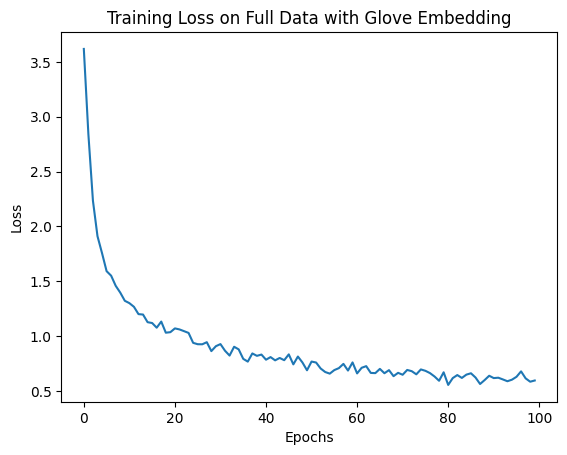

In [18]:
epochs, loss_per_epoch = train_full_data(NUM_EPOCHS, model, optimizer, criterion, train_data, VOCAB, batch_size=8)

# Plot the loss curve
plt.plot(epochs, loss_per_epoch)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss on Full Data with Glove Embedding')
plt.savefig("loss_full_data_glove_batching.png")
plt.show()

**Write the code for testing your model on the test data**

In [29]:
def test_model(model, test_data, glove_vectors, criterion, dim=glove_dim, batch_size=8):
    model.eval()
    torch.manual_seed(42)
    random.seed(42)
    np.random.seed(42)

    losses = []
    total_correct = 0
    total_questions = 0

    with torch.no_grad():
        for start_idx in range(0, len(test_data), batch_size):
            batch_data = test_data[start_idx:start_idx + batch_size]

            all_questions = []
            all_keys = []
            all_values = []
            all_targets = []
            memory_texts = []  # Track memory value strings per query

            for person_data in batch_data:
                random_person1, random_person2 = random.sample(test_data, 2)
                concat = person_data + random_person1 + random_person2

                keys = [sentence_embedding(row[1], glove_vectors, dim) for row in concat]
                values = [sentence_embedding(row[2], glove_vectors, dim) for row in concat]

                keys_tensor = torch.tensor(np.array(keys), dtype=torch.float32).to(device)
                values_tensor = torch.tensor(np.array(values), dtype=torch.float32).to(device)

                for entry in person_data:
                    q_vec = sentence_embedding(entry[1], glove_vectors, dim)
                    q_tensor = torch.tensor(q_vec, dtype=torch.float32).unsqueeze(0).to(device)
                    all_questions.append(q_tensor)

                    try:
                        target_idx = next(i for i, row in enumerate(concat) if row[1] == entry[1] and row[2] == entry[2])
                    except StopIteration:
                        print("Target not found in memory for question:", entry[1])
                        continue

                    all_keys.append(keys_tensor)
                    all_values.append(values_tensor)
                    all_targets.append(target_idx)
                    memory_texts.append([r[2] for r in concat])  # Store the value strings

            if not all_questions:
                continue

            questions = torch.cat(all_questions, dim=0)
            padded_keys = pad_sequences(all_keys)
            padded_values = pad_sequences(all_values)
            targets = torch.tensor(all_targets, dtype=torch.long).to(device)

            output = model(questions, padded_keys, padded_values)
            y = model.B(padded_values)
            inner_prod = torch.bmm(output.unsqueeze(1), y.transpose(1, 2)).squeeze(1)

            loss = criterion(inner_prod, targets)
            losses.append(loss.item())

            predicted = torch.argmax(inner_prod, dim=1)

            # Compare prediction to ground truth properly using saved memory_texts
            for i, pred_idx in enumerate(predicted):
                mem = memory_texts[i]
                pred_answer = mem[pred_idx]
                true_answer = mem[all_targets[i]]

                if pred_idx == all_targets[i]:
                    total_correct += 1

            total_questions += len(targets)

    avg_accuracy = total_correct / total_questions if total_questions else 0
    print(f"\n🧪 Test Accuracy: {avg_accuracy * 100:.2f}%")

    return losses, avg_accuracy



🧪 Test Accuracy: 60.08%


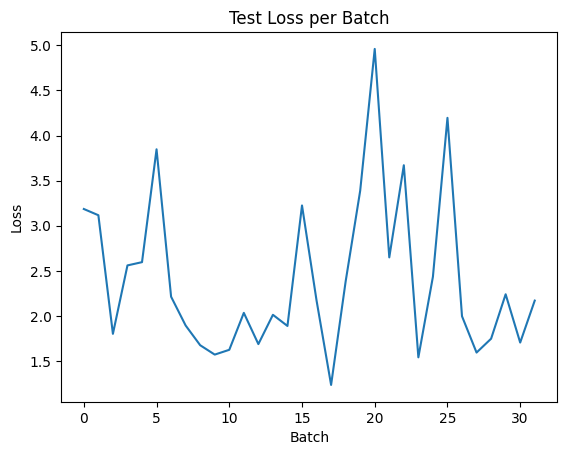

In [35]:
test_losses, test_accuracy = test_model(model, test_data, glove_vectors, criterion, dim=glove_dim, batch_size=32)

plt.plot(list(range(len(test_losses))),test_losses)
plt.title("Test Loss per Batch")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.savefig("test_loss.png")
plt.show()

# Part D: Use the Model 

Given a question in natural language, turn it into a bag of words and feed it into the model with a set of plausible keys and values. Apply the output feature embedding to the full set of values and pick the value with argmax. Return the actual text inside that value (not the bag of words or embedding).

That is, given a natural language question, you are asked to create the $q$ and pick a relevant subset of $k$ and $v$. Run the $q$, $k$, and $v$ through the model and get an answer to the original question.

For example a question might be "When was Alexander Hamilton born?" Depending on how you pre-proessed your data, you may need to extract the entity and the relation.

Write a function that takes in the `question` below, the data, and the model, and outputs the text answer, e.g., "11 january 1755". You must use your ``KVMemNet``.

**Suggestion:** To process a question you will probably want to find the entity and the relation. You may use packages such as [NLTK](https://www.nltk.org/) (already imported), [SpaCY](https://spacy.io/), [Stanza](https://stanfordnlp.github.io/stanza/), or other.

In [ ]:
question = "When was alexander hamilton born?"

**Create your function for using the `KVMemNet` to answer a given question.**

The function should take in the question, data, model, and any other parameters you need. The function should return a text string.

In [21]:
# Generate multiple questions templates for each type of relation
relation_templates = {
    "birth_date": [
        "When was {name} born?",
        "What is the birthdate of {name}?",
        "When is {name}'s birthday?"
    ],
    "birth_place": [
        "Where was {name} born?",
        "What is {name}'s place of birth?"
    ],
    "death_date": [
        "When did {name} die?",
        "What is {name}'s date of death?"
    ],
    "death_place": [
        "Where did {name} die?",
        "What was {name}'s place of death?"
    ],
    "president": [
        "Who was the president when {name} served?",
        "Under which president did {name} work?"
    ],
    "term_start": [
        "When did {name} begin their term?",
        "On what date did {name} assume their position?"
    ],
    "term_end": [
        "When did {name}'s term end?",
        "On what date did {name} step down?"
    ],
    "predecessor": [
        "Who was {name}'s predecessor?",
        "Who held the position before {name}?"
    ],
    "successor": [
        "Who took over after {name}?",
        "Who was {name}'s successor?"
    ],
    "spouse": [
        "Who is {name}'s spouse?",
        "Who did {name} marry?"
    ],
    "children": [
        "Who are {name}'s children?",
        "How many children does {name} have?"
    ],
    "alma_mater": [
        "Which college did {name} attend?",
        "Where did {name} receive their education?"
    ],

    "religion": [
        "What religion did {name} follow?",
        "What was {name}'s faith?"
    ],
    "party": [
        "What political party did {name} belong to?",
        "What was {name}'s party affiliation?"
    ],
    "office": [
        "What office did {name} hold?",
        "What positions did {name} serve in?"
    ],
    "rank": [
        "What was {name}'s military rank?",
        "What rank did {name} achieve?"
    ]
}

In [36]:
import random
# Generate questions from relation templates from test_data
def generate_qa_from_templates(test_data, templates_dict):
    qa_pairs = []

    for entity_data in test_data[:100]:
        used_relations = set()  # To avoid duplicates per person
        for entry in entity_data:
            name = entry[0].lower()
            relation = entry[1].replace(name, "").strip().lower()
            value = entry[2].lower()

            if relation in templates_dict and relation not in used_relations:
                template = random.choice(templates_dict[relation])  # Only one random question per relation
                question = template.format(name=name.title())
                qa_pairs.append((question, name, relation, value))
                used_relations.add(relation)  # Prevent adding multiple questions for same relation

    return qa_pairs

In [37]:
qa_pairs = generate_qa_from_templates(test_data, relation_templates)

In [39]:
# Use the model to answer questions
def answer_question_from_text(qa_pairs, data, model, glove_vectors, dim=100):
    question, entity, relation, ground_truth = qa_pairs

    # query was formed as entity and relation
    query_text = f"{entity} {relation}"
    query = sentence_embedding(query_text, glove_vectors, dim)
    query_tensor = torch.tensor(query, dtype=torch.float32).unsqueeze(0).to(device)

    person_keys = []
    person_values = []
    value_texts = []

    # Find the person's data
    target_rows = next((p for p in data if p[0][0].lower() == entity.lower()), None)
    if target_rows is None:
        return f"Could not find data for entity: {entity}"

    selected_data = [target_rows]

    # Sample distractors
    other_data = [d for d in data if d[0][0].lower() != entity.lower()]
    distractors = random.sample(other_data, k=2) if len(other_data) >= 2 else other_data
    selected_data += distractors

    for person_data in selected_data:
        for row in person_data:
            k_emb = sentence_embedding(row[1], glove_vectors, dim)
            v_emb = sentence_embedding(row[2], glove_vectors, dim)
            person_keys.append(k_emb)
            person_values.append(v_emb)
            value_texts.append(row[2])
            
    keys_tensor = torch.tensor(np.array(person_keys), dtype=torch.float32).unsqueeze(0).to(device)
    values_tensor = torch.tensor(np.array(person_values), dtype=torch.float32).unsqueeze(0).to(device)

    # Model inference
    with torch.no_grad():
        output = model(query_tensor, keys_tensor, values_tensor)
        y = model.B(values_tensor)
        scores = torch.bmm(output.unsqueeze(1), y.transpose(1, 2)).squeeze(1)
        pred_idx = torch.argmax(scores, dim=1).item()
        predicted_answer = value_texts[pred_idx]

    return predicted_answer

In [40]:
# To evaluate the model answering questions
correct = 0
total = 0

for qa in qa_pairs:
    question, name, relation, full_ground_truth = qa
    predicted_answer = answer_question_from_text(qa, test_data, model, glove_vectors, dim=100)

    # Remove name from predicted and ground truth
    name_lower = name.lower()
    gt_value_only = full_ground_truth.replace(name_lower, "").strip().lower()
    pred_value_only = predicted_answer.replace(name_lower, "").strip().lower()

    is_correct = pred_value_only == gt_value_only
    total += 1
    if is_correct:
        correct += 1

    print(f"Q: {qa[0]}")
    print(f"Predicted A: {pred_value_only}")
    print(f"Ground Truth: {gt_value_only}")
    print(f"✔️ Correct" if is_correct else "❌ Incorrect")
    print("-" * 50)

accuracy = correct / total * 100 if total > 0 else 0
print(f"Total Questions: {total}")
print(f"Correct Predictions: {correct}")
print(f"Accuracy: {accuracy:.2f}%")

Q: When did Edwin O. Stanard begin their term?
Predicted A: march 4 1873 1869
Ground Truth: march 4 1873 1869
✔️ Correct
--------------------------------------------------
Q: On what date did Edwin O. Stanard step down?
Predicted A: march 4 1873 1869
Ground Truth: march 3 1875 1871
❌ Incorrect
--------------------------------------------------
Q: What office did Edwin O. Stanard hold?
Predicted A: lieutenant governor of missouri
Ground Truth: lieutenant governor of missouri
✔️ Correct
--------------------------------------------------
Q: Who was Edwin O. Stanard's predecessor?
Predicted A: george smith
Ground Truth: george smith
✔️ Correct
--------------------------------------------------
Q: Who was Edwin O. Stanard's successor?
Predicted A: joseph j gravely
Ground Truth: joseph j gravely
✔️ Correct
--------------------------------------------------
Q: When was Edwin O. Stanard born?
Predicted A: january 5 1832
Ground Truth: january 5 1832
✔️ Correct
----------------------------------